In [1]:
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /Users/laks007/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2024-03-25 21:16:02.543857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# modeling
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# !wget https://dagshub.com/Omdena/HyderabadIndiaChapter_MentalHealthWellbeingFomoSocialMedia/raw/9624be1317f2735a0f84db62a3094bed0b087cf4/data/preprocessed_data/combined_data_sentiment_bert.csv

--2024-03-25 23:43:01--  https://dagshub.com/Omdena/HyderabadIndiaChapter_MentalHealthWellbeingFomoSocialMedia/raw/9624be1317f2735a0f84db62a3094bed0b087cf4/data/preprocessed_data/combined_data_sentiment_bert.csv
Resolving dagshub.com (dagshub.com)... 35.186.200.224
Connecting to dagshub.com (dagshub.com)|35.186.200.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘combined_data_sentiment_bert.csv.3’

combined_data_senti     [     <=>            ]  20.49M  21.4MB/s    in 1.0s    

2024-03-25 23:43:03 (21.4 MB/s) - ‘combined_data_sentiment_bert.csv.3’ saved [21487641]



In [3]:
curr_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(os.path.dirname(curr_dir)), 'data','preprocessed_data','combined_data_sentiment_bert.csv')

In [4]:
with open(data_path, 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

Text,Negative Score,Neutral Score,Positive Score,Predicted Sentiment

Each data point looks like this:

msm left pushing u mental health crisis coronavirus people sick,0.9619251,0.03580601,0.0022688184,Negative



In [5]:
df = pd.read_csv(data_path)
df.head()

,Text,Negative Score,Neutral Score,Positive Score,Predicted Sentiment
0,msm left pushing u mental health crisis corona...,0.9619251,0.03580601,0.0022688184,Negative
1,breaking democrat launched another investigati...,0.34864902,0.6255751,0.025775908,Neutral
2,trying get pro statehood people go vote thats ...,0.7294451,0.24873672,0.021818098,Negative
3,really sad even watch flunky cry whipped mind ...,0.9579343,0.039163336,0.002902385,Negative
4,lynn shelton one wonderful advisor sundance la...,0.29626048,0.495577,0.20816256,Neutral


In [6]:
df['Predicted Sentiment'].value_counts()

Negative               120756
Neutral                 83146
Positive                21098
Predicted Sentiment        44
Name: Predicted Sentiment, dtype: int64

In [7]:
df = df.rename(columns={'Predicted Sentiment':'Sentiment'})

In [9]:
#remove rows which has sentiment as predicted sentiment value other than neutral, positive, negetive
df = df[df['Sentiment']!='Predicted Sentiment']

In [10]:
df.head()

,Text,Negative Score,Neutral Score,Positive Score,Sentiment
0,msm left pushing u mental health crisis corona...,0.9619251,0.03580601,0.0022688184,Negative
1,breaking democrat launched another investigati...,0.34864902,0.6255751,0.025775908,Neutral
2,trying get pro statehood people go vote thats ...,0.7294451,0.24873672,0.021818098,Negative
3,really sad even watch flunky cry whipped mind ...,0.9579343,0.039163336,0.002902385,Negative
4,lynn shelton one wonderful advisor sundance la...,0.29626048,0.495577,0.20816256,Neutral


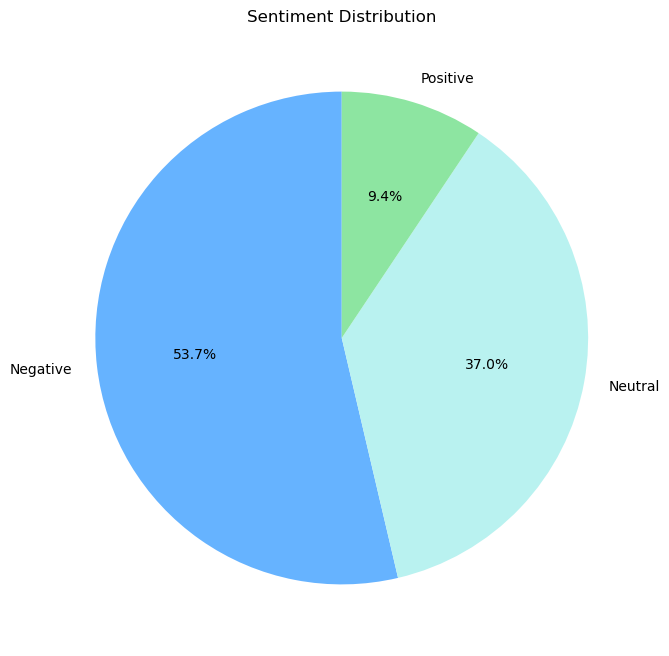

In [11]:
class_percentages = df['Sentiment'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
plt.pie(class_percentages, labels=class_percentages.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#b9f2f0', '#8de5a1'])
plt.title('Sentiment Distribution')
plt.show()

In [12]:
df['Sentiment'].value_counts()

Negative    120756
Neutral      83146
Positive     21098
Name: Sentiment, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225000 entries, 0 to 225043
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Text            225000 non-null  object
 1   Negative Score  225000 non-null  object
 2   Neutral Score   225000 non-null  object
 3   Positive Score  225000 non-null  object
 4   Sentiment       225000 non-null  object
dtypes: object(5)
memory usage: 10.3+ MB


In [14]:
# encode the label
df.loc[df['Sentiment'] == 'Negative', 'Label'] = 0
df.loc[df['Sentiment'] == 'Neutral', 'Label'] = 1
df.loc[df['Sentiment'] == 'Positive', 'Label'] = 2

In [22]:
df.head()

,Text,Negative Score,Neutral Score,Positive Score,Sentiment,Label
0,msm left pushing u mental health crisis corona...,0.9619251,0.03580601,0.0022688184,Negative,0.0
1,breaking democrat launched another investigati...,0.34864902,0.6255751,0.025775908,Neutral,1.0
2,trying get pro statehood people go vote thats ...,0.7294451,0.24873672,0.021818098,Negative,0.0
3,really sad even watch flunky cry whipped mind ...,0.9579343,0.039163336,0.002902385,Negative,0.0
4,lynn shelton one wonderful advisor sundance la...,0.29626048,0.495577,0.20816256,Neutral,1.0


In [15]:
# splitting dataset into 3 sets: training, validation, testing with split ratio of 70%:15%:15%

from sklearn.model_selection import train_test_split

# Remove NaN values from 'df'
df = df.dropna()

# Split data to train, validation, test set
X_train, X_temp, y_train, y_temp = train_test_split(df['Text'], df['Label'], test_size=0.3, random_state=42)

# Further split the remaining data into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Show how many data in each set
print("Length of train set:", len(X_train))
print("Length of validation set:", len(X_val))
print("Length of test set:", len(X_test))

Length of train set: 157500
Length of validation set: 33750
Length of test set: 33750


In [16]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words

X_train_preprocessed = X_train.apply(process_message)
X_train_preprocessed

168560    [moramo nastavimo, nastavimo radom, radom bolj...
3873      [still sad, sad tbh, tbh remember, remember wa...
224694    [learned certain, certain mental, mental healt...
89471     [sad idec, idec show, show tube, tube anything...
161260    [potential downside, downside enormous, enormo...
                                ...                        
119902    [sheriff call, call amp, amp say, say guy, guy...
103714    [angry mob, mob worked, worked frenzy, frenzy ...
131958    [yup allegation, allegation misconduct, miscon...
146896    [sad fred, fred last, last tweet, tweet losing...
121982    [speak lupe, lupe release, release snyder, sny...
Name: Text, Length: 157500, dtype: object

In [17]:
X_val_preprocessed = X_val.apply(process_message)
X_test_preprocessed = X_test.apply(process_message)

In [18]:
# join words into sentence
X_train_ready = X_train_preprocessed.str.join(' ')
X_train_ready[1]

'breaking democrat democrat launched launched another another investigation investigation donald donald time time legal legal firing firing partisan'

In [19]:
X_val_ready = X_val_preprocessed.str.join(' ')
X_test_ready = X_test_preprocessed.str.join(' ')


## Models

### NB

In [20]:
# Naive Bayes

nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train_ready, y_train)

valid_predict_nb = nb.predict(X_val_ready)

train_accuracy = nb.score(X_train_ready, y_train)*100
valid_accuracy_nb = accuracy_score(valid_predict_nb, y_val)*100

print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy))
print("Naive Bayes Validation Accuracy Score  : {}% ".format(valid_accuracy_nb))
print()
print(classification_report(valid_predict_nb, y_val))

Naive Bayes Train Accuracy Score : 80.66285714285715% 
Naive Bayes Validation Accuracy Score  : 77.73037037037037% 

              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84     22951
         1.0       0.63      0.82      0.72      9562
         2.0       0.37      0.97      0.53      1237

    accuracy                           0.78     33750
   macro avg       0.65      0.85      0.70     33750
weighted avg       0.84      0.78      0.79     33750



In [45]:
message = 'i am wonderful today'
p_msg = process_message(message)
pred_label = nb.predict(p_msg)
pred_label


array([1.])

### SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define TF-IDF vectorizer and SVM classifier in a Pipeline
svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)),
    ('clf', SVC(kernel='rbf'))  # Use RBF kernel
])

# Fit the SVM model
svm.fit(X_train_ready, y_train)

# Predict on validation set
valid_predict_svm = svm.predict(X_val_ready)

# Calculate accuracy scores
train_accuracy_svm = svm.score(X_train_ready, y_train) * 100
valid_accuracy_svm = accuracy_score(valid_predict_svm, y_val) * 100

# Print accuracy scores
print("SVM Train Accuracy Score : {}%".format(train_accuracy_svm))
print("SVM Validation Accuracy Score: {}%".format(valid_accuracy_svm))
print()
print(classification_report(valid_predict_svm, y_val))


### RF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


# Define the pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100)),
])

# Train the model
rf_pipeline.fit(X_train_ready, y_train)

# Predict on the validation set
valid_predict_rf = rf_pipeline.predict(X_val)

# Calculate and print the accuracy and classification report
print("Random Forest Validation Accuracy Score:", accuracy_score(y_val, valid_predict_rf))
print(classification_report(y_val, valid_predict_rf))


KeyboardInterrupt: 

### Using LSTM

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Tokenizing texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding sequences
max_length = max([len(x) for x in X_train_seq])  # Get max sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Define LSTM model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=5)

# Predict on the validation set
valid_predict_lstm = model.predict(X_val_pad)
valid_predict_lstm = [1 if prob > 0.5 else 0 for prob in valid_predict_lstm]

# Calculate and print the accuracy and classification report
print("LSTM Validation Accuracy Score:", accuracy_score(y_val, valid_predict_lstm))
print(classification_report(y_val, valid_predict_lstm))


Epoch 1/5
4922/4922 [==============================] - 399s 80ms/step - loss: -6.0429 - accuracy: 0.7221
Epoch 2/5
2177/4922 [============>.................] - ETA: 3:39 - loss: -21.1714 - accuracy: 0.8070

KeyboardInterrupt: 

### lightgbm

In [ ]:
pip install lightgbm


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Define the pipeline
lgbm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', lgb.LGBMClassifier())
])

# Train the model
lgbm_pipeline.fit(X_train, y_train)

# Predict on the validation set
valid_predict_lgbm = lgbm_pipeline.predict(X_val)

# Calculate and print the accuracy and classification report
valid_accuracy_lgbm = accuracy_score(y_val, valid_predict_lgbm) * 100
print(f"LightGBM Validation Accuracy Score: {valid_accuracy_lgbm:.2f}%")
print(classification_report(y_val, valid_predict_lgbm))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 9.577326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163087
[LightGBM] [Info] Number of data points in the train set: 157500, number of used features: 5587
[LightGBM] [Info] Start training from score -0.621042
[LightGBM] [Info] Start training from score -0.995248
[LightGBM] [Info] Start training from score -2.375326
LightGBM Validation Accuracy Score: 85.18%
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     18029
         1.0       0.82      0.81      0.81     12474
         2.0       0.86      0.70      0.77      3247

    accuracy                           0.85     33750
   macro avg       0.85      0.81      0.83     33750
weighted avg       0.85      0.85      0.85     33750



### roberta

In [ ]:
pip install transformers torch


In [ ]:
pip install transformers[torch]

In [ ]:
import transformers
import accelerate
import torch
print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)
print("Torch version:", torch.__version__)


Transformers version: 4.39.1
Accelerate version: 0.28.0
Torch version: 2.2.1+cu121


In [ ]:
!pip install accelerate==0.21.0
!pip install transformers==4.5.0


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokenized = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        input_ids = tokenized['input_ids'][0]
        attention_mask = tokenized['attention_mask'][0]
        if self.labels is not None:
            label = self.labels[idx]
            return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": torch.tensor(label)}
        return {"input_ids": input_ids, "attention_mask": attention_mask}

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create the datasets
train_dataset = CustomDataset(tokenizer, X_train_ready, y_train)
val_dataset = CustomDataset(tokenizer, X_val, y_val)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).mean()}
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)


### XGB

In [48]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/45/6d/8c1d2570a52db6263d855c3ee3daf8f4bdf4a365cd6610772d6fce5fd904/xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
Using cached xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl (2.2 MB)


In [49]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Define the pipeline
xgb = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', XGBClassifier()),  # Using XGBoost classifier
               ])

# Train the model
xgb.fit(X_train, y_train)

# Predict on validation set
valid_predict_xgb = xgb.predict(X_val)

# Calculate accuracies
train_accuracy_xgb = xgb.score(X_train, y_train) * 100
valid_accuracy_xgb = accuracy_score(valid_predict_xgb, y_val) * 100

# Print accuracy scores
print("XGBoost Train Accuracy Score : {:.2f}% ".format(train_accuracy_xgb))
print("XGBoost Validation Accuracy Score : {:.2f}% ".format(valid_accuracy_xgb))
print()
print(classification_report(valid_predict_xgb, y_val))


XGBoost Train Accuracy Score : 85.53% 
XGBoost Validation Accuracy Score : 84.42% 

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     18663
           1       0.82      0.80      0.81     12707
           2       0.65      0.89      0.75      2380

    accuracy                           0.84     33750
   macro avg       0.79      0.85      0.81     33750
weighted avg       0.85      0.84      0.85     33750



In [51]:
#save model
with open('sentiment_classifier.pkl', 'wb') as f:
            pickle.dump(xgb, f)

In [80]:
#load model
with open('sentiment_classifier.pkl', 'rb') as file:
    xgb_loaded = pickle.load(file)

In [73]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

def process_message(message, lower_case=True, stem=True, stop_words=True):
    if lower_case:
        message = message.lower()
    
    words = word_tokenize(message)
    
    if stop_words:
        sw = set(stopwords.words('english'))
        words = [word for word in words if word not in sw]
    
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

In [77]:
msg = 'i am feeling sad'
processed_msg = process_message(msg)
pred_label = xgb.predict([processed_msg])
pred_label

array([0])

### Roberta

In [ ]:
pip install transformers torch


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

# Define a custom dataset class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokenized_input = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        input_ids = tokenized_input['input_ids'][0]
        attention_mask = tokenized_input['attention_mask'][0]
        if self.labels is not None:
            label = torch.tensor(self.labels[idx])
            return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}
        return {'input_ids': input_ids, 'attention_mask': attention_mask}


# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Prepare datasets
train_dataset = TextDataset(tokenizer, X_train_ready, y_train)
val_dataset = TextDataset(tokenizer, X_val, y_val)

# Training arguments
training_args = TrainingArguments(
    output_dir='./roberta_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train and evaluate
trainer.train()
trainer.evaluate()
